# Spectral calustering

### Important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from DataMatrix import generate_data_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import euclidean_distances
import warnings
warnings.filterwarnings("ignore")

-  **Create an object from DataMatrix class to use it for loading the data in the two solution methods**

## Spectral clustering implementation

- similarity matrix

In [2]:
def similarity_matrix(X, sigma=0.1):
    pairwise_sq_dists = np.square(pairwise_distances(X, metric='euclidean'))
    return np.exp(-pairwise_sq_dists / (2. * sigma ** 2))

In [3]:
def knn_similarity_matrix(X, n_neighbors=10):
    return kneighbors_graph(X, n_neighbors=n_neighbors, mode='connectivity', include_self=True).toarray()

In [4]:
def consine_similarity_matrix(X):
    X = normalize(X)
    return X.dot(X.T)

- laplacian-a matrix

In [5]:
def laplacian_a_matrix(W):
    D = np.diag(np.sum(W, axis=1))
    D_inv = np.linalg.inv(D)
    I = np.eye(len(D))
    return I - np.dot(D_inv, W)


In [6]:
def normalized_laplacian(W):
    D = np.diag(np.sum(W, axis=1))
    D_sqrt_inv = np.diag(1.0 / np.sqrt(np.sum(W, axis=1)))
    return np.dot(D_sqrt_inv, np.dot(D - W, D_sqrt_inv))

- spectral clustering

In [7]:
def spectral_clustering(X, n_clusters=19,sim='ecu' ,laplacian='a',n_neighbours=10,sigma=0.1):
    if sim == "ecu":
        W = similarity_matrix(X, sigma)
    elif sim == "cos":
        W = consine_similarity_matrix(X)
    else:
        W = knn_similarity_matrix(X,n_neighbors=n_neighbours)
    print(W)
    if laplacian == 'a':
        L = laplacian_a_matrix(W)
    else:
        L = normalized_laplacian(W)
    eigenvalues, eigenvectors = np.linalg.eig(L)
    idx = eigenvalues.argsort()  # Sort eigenvalues in ascending order
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = np.real(eigenvectors)
    norm_eigenvectors = normalize(eigenvectors[:, :n_clusters], norm='l2', axis=1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(norm_eigenvectors)
    return kmeans

### load the data in the first solution method `Mean Method`

In [8]:
x_train,y_train,x_test,y_test = generate_data_matrix(method="mean")
print("X_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (7296, 45)
y_train shape:  (7296, 1)
X_test shape:  (1824, 45)
y_test shape:  (1824, 1)


In [9]:
kmean = spectral_clustering(x_train, n_clusters=19,sim="knn",laplacian='a',sigma=0.1)

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.metrics.pairwise import euclidean_distances

def evaluate_spectral_clustering(X_train, y_train, X_test, y_test, kmeans_model):
    # Compute cluster centroids from the kmeans_model
    cluster_centers = kmeans_model.cluster_centers_
    
    # Calculate the similarity between each data point and cluster centroids
    similarities = -euclidean_distances(X_test, cluster_centers)  # Using negative Euclidean distance as similarity
    
    # Assign each data point to the nearest cluster
    test_labels = similarities.argmax(axis=1)
    
    # Compute clustering evaluation metrics
    silhouette = silhouette_score(X_test, test_labels)
    davies_bouldin = davies_bouldin_score(X_test, test_labels)
    rand_index = adjusted_rand_score(y_test, test_labels)  # Adjusted Rand index requires true labels
    
    return silhouette, davies_bouldin, rand_index

silhouette, davies_bouldin, rand_index = evaluate_spectral_clustering(x_train, y_train, x_test, y_test, kmean)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 45 while Y.shape[1] == 19

In [11]:
from sklearn.metrics import confusion_matrix

def precision_recall_f1_entropy(true_labels, cluster_labels, n_clusters):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, cluster_labels)
    print(cm)
    
    # Compute precision, recall, and F1 score
    precision = np.zeros(n_clusters)
    recall = np.zeros(n_clusters)
    f1_score = np.zeros(n_clusters)
    entropy = 0.0
    
    for cluster in range(n_clusters):
        tp = cm[cluster, cluster]  # True Positives
        fp = np.sum(cm[:, cluster]) - tp  # False Positives
        fn = np.sum(cm[cluster, :]) - tp  # False Negatives
        
        precision[cluster] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[cluster] = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score[cluster] = 2 * precision[cluster] * recall[cluster] / (precision[cluster] + recall[cluster]) if (precision[cluster] + recall[cluster]) > 0 else 0.0
    
    # Compute entropy
    total_samples = np.sum(cm)
    for cluster in range(n_clusters):
        cluster_prob = np.sum(cm[cluster]) / total_samples
        if cluster_prob > 0:
            entropy += -cluster_prob * np.log2(cluster_prob)
    
    # Compute average precision, recall, F1 score, and normalize entropy
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)
    normalized_entropy = entropy / np.log2(n_clusters)  # Normalize entropy
    
    return avg_precision, avg_recall, avg_f1_score, normalized_entropy

# Compute evaluation metrics
precision, recall, f1_score, entropy = precision_recall_f1_entropy(y_train, kmean.labels_, n_clusters=19)
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1_score))
print("Entropy: {:.4f}".format(entropy))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0  24 128   0   0  16  71   0   0   0   0  25  24   0   0   0
   96   0]
 [  0   0   0  48  19   0  48   0  48   0   0   0  48   0  77  48   0   0
   48   0]
 [  0   0   0   0  74   0   0   0 130   0   0   0  16   0   0 108   0   0
   56   0]
 [  0   0   0  82  96   0   0   0 124   0   0   0   0   0   0   0   0   0
   82   0]
 [  0   0   0   0   0   0   0   2   0   0   0 381   0   0   1   0   0   0
    0   0]
 [  0  50   0   0   0   0   5   0   0   0 103 130   0   0   0   0   0   0
   96   0]
 [  0 131   0   0   0   0   0   0  10   0   0 183   0   0   0   0   0   0
   60   0]
 [  0 180   0   0   0   0  84   3   0   2   6  86   0   0   3   0   0   0
   20   0]
 [  0   0   0 241   0   0  50   0  12  78   0   3   0   0   0   0   0   0
    0   0]
 [265   0   0  23   0   0   0   0   0  48   0   0   0   0   0   0   0   0
   48   0]
 [240   0   0   8   0   0   0  48   0  40   0   0   0   0   0   0

In [12]:
l=kmean.labels_

### load the data in the second solution method `Flatten Method`

In [ ]:
# x_train, x_test, y_train, y_test= generate_data_matrix(method="flatten")
# print("X_train shape: ", x_train.shape)
# print("y_train shape: ", y_train.shape)
# print("X_test shape: ", x_test.shape)
# print("y_test shape: ", y_test.shape)

## Measurement method 

In [13]:
def construct_clusters(true_labels,labels):
    clusters = {}
    for i in range(len(true_labels)):
        if labels[i] in clusters:
            clusters[labels[i]].append(true_labels[i])
        else:
            clusters[labels[i]]=[true_labels[i]]
    return clusters

In [14]:
clusters=construct_clusters(y_train.flatten(),l)
clusters

{18: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  

### Entropy method

In [15]:
# function to compute the conditional entropy of the clusters
def conditional_entropy(clusters,n_samples):
    H = 0
    for cluster in clusters.values():
        n = len(cluster)
        s=-sum([(cluster.count(label)/n) * np.log2(cluster.count(label)/n) for label in set(cluster)])
        H += (n/n_samples) * s
    return H

### Precision & Recall method

In [16]:
def precision_recall(clusters):
    precision = 0
    recall = 0
    for cluster in clusters.values():
        mx=0
        val=0
        for i in set(cluster):
            x=cluster.count(i)
            if x > mx:
                mx = x
                val = i
        p = mx/len(cluster)
        num_val=mx
        for cluster2 in clusters.values():
            if cluster != cluster2:
                num_val+=cluster2.count(val)
        r = mx/num_val
        precision += p
        recall += r
        
    return precision/len(clusters),recall/len(clusters)

### F1 score method

In [17]:
def f_measure( clusters):
    f = 0
    num_clusters = len(clusters)
    for cluster in clusters.values():
        mx=0
        val=0
        for i in set(cluster):
            x=cluster.count(i)
            if x > mx:
                mx = x
                val = i
        p = mx/len(cluster)
        num_val=mx
        for cluster2 in clusters.values():
            if cluster != cluster2:
                num_val+=cluster2.count(val)
        r = mx/num_val
        f += (2*p*r)/(p+r)
    return f/num_clusters

In [18]:
# get the acuracy, conditional entropy, precision, recall and f-measure
def get_metrics(true_labels,labels):
    clusters=construct_clusters(true_labels,labels)
    n_samples = len(true_labels)
    H = conditional_entropy(clusters,n_samples)
    precision,recall = precision_recall(clusters)
    f = f_measure(clusters)
    return H,precision,recall,f

print(get_metrics(y_train.flatten(),l))

(1.8867647298541435, 0.4834516126412914, 0.45819627192982465, 0.4357207303374417)


In [21]:
def spectral_clustering_analysis(X_train, n_clusters=19):
    labels={}
    sim = ["ecu", "knn"]
    laplacian = ["a", "l"]
    n_neighbours = [5, 10, 15]
    sigma = [0.01,0.1, 0.5, 1]
    for s in sim:
        for l in laplacian:
            if s == "knn":
                for n in n_neighbours:
                    kmean = spectral_clustering(X_train, n_clusters=n_clusters, sim=s, laplacian=l, n_neighbours=n)
                    print(s+"_"+l+"_"+str(n))
                    labels[s+"_"+l+"_"+str(n)] = kmean.labels_
            else:
                for sig in sigma:
                    kmean = spectral_clustering(X_train, n_clusters=n_clusters, sim=s, laplacian=l, sigma=sig)
                    print(s+"_"+l+"_"+str(sig))
                    labels[s+"_"+l+"_"+str(sig)] = kmean.labels_
                    
    return labels

[[1.00000000e+00 5.44003617e-32 3.63804242e-87 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.44003617e-32 1.00000000e+00 1.43594693e-21 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.63804242e-87 1.43594693e-21 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
[[1.         0.48680611 0.1366497  ... 0.         0.         0.        ]
 [0.48680611 1.         0.61883003 ... 0.         0.         0.        ]
 [0.1366497  0.61883003 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.    

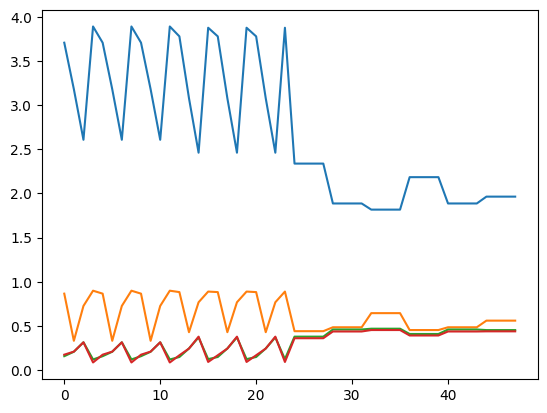

In [22]:
def get_best_params(labels):
    metrics = {}
    best_key = ""
    for key in labels:
        H,precision,recall,f = get_metrics(y_train.flatten(),labels[key])
        metrics[key] = [H,precision,recall,f]
        if best_key == "":
            best_key = key
        elif H < metrics[best_key][0]:
            best_key = key
    print(best_key)
    print(metrics[best_key])
    return metrics

def plot_metrics(metrics):
    H = []
    precision = []
    recall = []
    f = []
    for key in metrics:
        H.append(metrics[key][0])
        precision.append(metrics[key][1])
        recall.append(metrics[key][2])
        f.append(metrics[key][3])
    plt.plot(H)
    plt.plot(precision)
    plt.plot(recall)
    plt.plot(f)
    plt.show()

labels_dic= spectral_clustering_analysis(x_train, n_clusters=19)
metrics = get_best_params(labels_dic)
plot_metrics(metrics)


In [23]:
print (labels_dic)

{'ecu_a_5_0.01': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_a_5_0.1': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_a_5_0.5': array([1, 1, 1, ..., 2, 2, 2]), 'ecu_a_5_1': array([0, 0, 0, ..., 8, 0, 0]), 'ecu_a_10_0.01': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_a_10_0.1': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_a_10_0.5': array([1, 1, 1, ..., 2, 2, 2]), 'ecu_a_10_1': array([0, 0, 0, ..., 8, 0, 0]), 'ecu_a_15_0.01': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_a_15_0.1': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_a_15_0.5': array([1, 1, 1, ..., 2, 2, 2]), 'ecu_a_15_1': array([0, 0, 0, ..., 8, 0, 0]), 'ecu_l_5_0.01': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_l_5_0.1': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_l_5_0.5': array([1, 1, 1, ..., 2, 2, 2]), 'ecu_l_5_1': array([ 0,  0,  0, ..., 13,  0,  0]), 'ecu_l_10_0.01': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_l_10_0.1': array([0, 0, 0, ..., 0, 0, 0]), 'ecu_l_10_0.5': array([1, 1, 1, ..., 2, 2, 2]), 'ecu_l_10_1': array([ 0,  0,  0, ..., 13,  0,  0]), 'ecu_l_15_0.01': array([0, 0, 0, ..., 0,

In [ ]:
from sklearn.model_selection import GridSearchCV

def tune_parameters(X, sigma_range):
    param_grid = {'sigma': sigma_range}
    grid_search = GridSearchCV(estimator=spectral_clustering, param_grid=param_grid, cv=5)
    grid_search.fit(X)
    return grid_search.best_params_
